# Goals
- explore data by location, restaurant type
- predict inspection grade based on description
- topic model descriptions
- cluster inspector "types"
- evaluate subjectivity/consistency of inspections

evaluation: critical/not critical -> score -> grade

classification prediction:
do inspector comment's indicate grade level?
class-imbalance - low # of C's

topic modeling:
are there specific topics based on borough?
what are frequent reasons for A vs B/C grading?
topic model Grade A
topic model Grade B/C
retrieve weights of terms?
investigate consistency of inspector comments

visualization:
t-sne, cloud-plot, pyLDAvis

word embeddings?
label docs based on topics and predict?

# Notes

## Grades
- Not Yet Graded
- A = Grade A
- B = Grade B
- C = Grade C
- Z = Grade Pending
- P = Grade Pending issued on re-opening following an initial inspection that resulted in a closure

# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sklearn

In [2]:
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# Data

In [3]:
filename = 'data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv'

In [4]:
# read in random sample from csv
n = sum(1 for line in open(filename)) - 1 # number of records in file (excludes header)
s = 2000 # desired sample size
skip = sorted(random.sample(range(1, n+1), n-s)) # the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)

In [6]:
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,50045630,MOKJA,MANHATTAN,852,AMSTERDAM AVE,10025.0,6469654296,Korean,11/29/2017,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,18.0,NaN,NaN,10/03/2018,Cycle Inspection / Initial Inspection
1,50070744,WASABI SUSHI BENTO 6TH AVE,MANHATTAN,1016,6TH AVE,10018.0,9172614132,Japanese,11/24/2017,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,Not Critical,23.0,NaN,NaN,10/03/2018,Pre-permit (Operational) / Initial Inspection
2,50068380,VAN LEEWEN ARTISAN ICE CREAM,MANHATTAN,172,LUDLOW ST,10002.0,7187011630,"Ice Cream, Gelato, Yogurt, Ices",11/08/2017,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Critical,13.0,A,11/08/2017,10/03/2018,Pre-permit (Operational) / Initial Inspection
3,50009773,LAS LUNITAS,BROOKLYN,195,STANHOPE ST,11237.0,7184839037,"Latin (Cuban, Dominican, Puerto Rican, South &...",04/01/2016,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,Not Critical,20.0,B,04/01/2016,10/03/2018,Cycle Inspection / Re-inspection
4,40376495,MARCO POLO RISTORANTE,BROOKLYN,345,COURT STREET,11231.0,7188525015,Italian,02/01/2018,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,13.0,A,02/01/2018,10/03/2018,Cycle Inspection / Initial Inspection


In [50]:
df.loc[1, 'VIOLATION DESCRIPTION']

'Proper sanitization not provided for utensil ware washing operation.'

In [51]:
df['VIOLATION DESCRIPTION'].value_counts()

Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                                                                                             272
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.                                                                                                                                                                                                                                          209
Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.                                                                                                                          

In [48]:
df['VIOLATION CODE'].value_counts()

10F    272
08A    209
06D    141
04L    139
06C    137
02G    120
02B    109
04N    107
10B    104
06F     47
04A     41
06E     41
08C     35
04M     35
06A     33
04H     29
09C     29
10H     24
10I     24
09B     21
10E     19
02H     17
20F     17
04K     17
04C     15
10D     15
05D     15
22C     13
06B     12
05H     12
      ... 
09A      8
15F      7
22A      6
20D      6
05F      6
16C      4
03A      4
10A      4
02I      3
22F      3
10C      3
20E      3
16A      3
20A      3
16E      3
16D      3
15I      2
04O      2
15K      2
06G      2
03B      1
02C      1
03G      1
15E      1
16F      1
08B      1
04E      1
04D      1
02E      1
05E      1
Name: VIOLATION CODE, Length: 64, dtype: int64

In [33]:
# inspections per boro
df['BORO'].value_counts()

MANHATTAN        765
BROOKLYN         526
QUEENS           454
BRONX            187
STATEN ISLAND     68
Name: BORO, dtype: int64

In [35]:
# inspections per zipcode
df['ZIPCODE'].value_counts()

10003.0    49
10019.0    45
10036.0    44
10001.0    43
10002.0    42
10016.0    37
11211.0    36
10011.0    35
10018.0    35
10012.0    35
11354.0    35
10013.0    34
10014.0    33
11385.0    33
10017.0    32
11372.0    29
10022.0    28
11201.0    26
11226.0    23
11238.0    23
11220.0    23
11214.0    21
11237.0    20
11209.0    20
11215.0    20
11377.0    19
11203.0    19
11223.0    18
11355.0    18
10009.0    17
           ..
11421.0     3
11428.0     3
11366.0     2
10039.0     2
10112.0     2
11434.0     2
10307.0     2
11692.0     2
11109.0     2
11693.0     2
10121.0     2
10004.0     2
10118.0     2
11357.0     2
10304.0     2
11411.0     1
10280.0     1
11004.0     1
10119.0     1
11414.0     1
11360.0     1
11365.0     1
11429.0     1
10282.0     1
11423.0     1
10103.0     1
10037.0     1
10111.0     1
10006.0     1
10020.0     1
Name: ZIPCODE, Length: 182, dtype: int64

In [36]:
# inspections per restaurant type
df['CUISINE DESCRIPTION'].value_counts()

American                                                            412
Chinese                                                             215
CafÃ©/Coffee/Tea                                                    105
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     98
Pizza                                                                96
Italian                                                              93
Japanese                                                             77
Mexican                                                              77
Spanish                                                              67
Caribbean                                                            65
Bakery                                                               53
Pizza/Italian                                                        50
Asian                                                                43
Chicken                                                         

In [37]:
# critical vs not
df['CRITICAL FLAG'].value_counts()

Critical          1100
Not Critical       862
Not Applicable      38
Name: CRITICAL FLAG, dtype: int64

In [42]:
# inspections per inspection type
df['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                      1143
Cycle Inspection / Re-inspection                            495
Pre-permit (Operational) / Initial Inspection               127
Pre-permit (Operational) / Re-inspection                     68
Administrative Miscellaneous / Initial Inspection            44
Smoke-Free Air Act / Initial Inspection                      18
Pre-permit (Non-operational) / Initial Inspection            18
Administrative Miscellaneous / Re-inspection                 15
Cycle Inspection / Reopening Inspection                      14
Trans Fat / Initial Inspection                               14
Calorie Posting / Initial Inspection                          9
Trans Fat / Re-inspection                                     5
Pre-permit (Operational) / Reopening Inspection               5
Inter-Agency Task Force / Initial Inspection                  5
Pre-permit (Operational) / Compliance Inspection              4
Smoke-Free Air Act / Re-inspection      

In [44]:
# inspection grades
df['GRADE'].value_counts()

A                 849
B                 121
Z                  24
C                  24
P                  14
Not Yet Graded      9
Name: GRADE, dtype: int64

In [41]:
# missing grade values
df['GRADE'].isna().sum()

959

In [39]:
# missing score values
df['SCORE'].isna().sum()

115

In [4]:
df_insp = df.loc[:, ['CAMIS', 'VIOLATION DESCRIPTION', 'GRADE']].copy()
df_insp.head()

,CAMIS,VIOLATION DESCRIPTION,GRADE
0,41399771,Non-food contact surface improperly constructe...,A
1,50052746,Filth flies or food/refuse/sewage-associated (...,Z
2,40402418,Facility not vermin proof. Harborage or condit...,NaN
3,41448603,Non-food contact surface improperly constructe...,P
4,50045630,Evidence of mice or live mice present in facil...,NaN


In [5]:
df_insp['VIOLATION DESCRIPTION'][1]

'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.'

In [6]:
df_insp.set_index('CAMIS', inplace=True)
df_insp.head()

,VIOLATION DESCRIPTION,GRADE
CAMIS,,
41399771,Non-food contact surface improperly constructe...,A
50052746,Filth flies or food/refuse/sewage-associated (...,Z
40402418,Facility not vermin proof. Harborage or condit...,NaN
41448603,Non-food contact surface improperly constructe...,P
50045630,Evidence of mice or live mice present in facil...,NaN


# Process Data

In [7]:
df_insp.groupby('GRADE').size()

GRADE
A                 829
B                 141
C                  41
Not Yet Graded      9
P                  12
Z                  36
dtype: int64

## Remove NaNs

In [8]:
len(df_insp)

2000

In [9]:
df_insp.dropna(inplace=True)
len(df_insp)

1053

## Remove Infrequent Grades

In [10]:
df_grd_num = df_insp.groupby('GRADE').size()
rem_grds = df_grd_num[(df_grd_num < 10).values].index

In [11]:
df_insp = df_insp[~df_insp['GRADE'].isin(rem_grds)]

## Vectorize Comments

In [12]:
vectorizer = TfidfVectorizer(stop_words='english')

In [13]:
X = pd.DataFrame(vectorizer.fit_transform(df_insp['VIOLATION DESCRIPTION']).toarray(), 
                 columns=vectorizer.get_feature_names())
X.head()

,140âº,38,41âº,65âº,70âº,acceptable,accessibility,accordance,accurate,active,...,ware,wash,washed,washing,waste,water,wiping,worker,worn,âºf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.187247,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.243512,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.187247,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X.set_index(df_insp.index, inplace=True)

## Test/Train Split

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, df_insp['GRADE'], test_size=0.2, random_state=0)

In [16]:
X_train.head()

,140âº,38,41âº,65âº,70âº,acceptable,accessibility,accordance,accurate,active,...,ware,wash,washed,washing,waste,water,wiping,worker,worn,âºf
CAMIS,,,,,,,,,,,,,,,,,,,,,
50050190,0.548584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50033076,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50077583,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.342115,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50001584,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40397886,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
y_train.head()

CAMIS
50050190    A
50033076    A
50077583    A
50001584    B
40397886    A
Name: GRADE, dtype: object

In [18]:
X_train.shape

(828, 280)

# Classify Comments

## Naive-Bayes

In [19]:
nb = MultinomialNB()
scores = model_selection.cross_val_score(nb, X_train, y_train, cv=10)
np.mean(scores)

0.7407734642272794

In [20]:
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.7294685990338164

# Topic Modeling

## Optimal Number of Topics

In [21]:
from sklearn.cluster import KMeans

In [22]:
k_inertia = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train.values)
    k_inertia.append(km.inertia_)

Text(0.5,1,'Elbow Method For Optimal k')

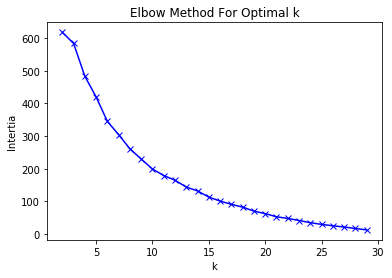

In [23]:
plt.plot(K, k_inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Intertia')
plt.title('Elbow Method For Optimal k')

## Topics

In [24]:
from sklearn.decomposition import NMF

In [25]:
nmf = NMF(n_components=9, random_state = 0)

In [26]:
nmf.fit(X_train)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=9, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [27]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [28]:
print_top_words(nmf, X_train.columns, 15)


Topic #0:improperly surface contact non food allow spaced unacceptable material movable cleaning accessibility unit sides raised

Topic #1:following rinsed occurred washed activity sanitized use contamination surface contact properly food maintained utensil including

Topic #2:vermin harborage conducive conditions attracting exist proof allowing premises facility roaches hand live wash present

Topic #3:protected display potential transportation source storage service preparation contamination food dispensed reused single stored required

Topic #4:âºf smoked 38 necessary fish oxygen packaged cold reduced foods 41âº item held preparation food

Topic #5:properly drained floor prevention plumbing backflow disposal anti functioning siphonage device installed disrepair required provided

Topic #6:flies house filth include associated refuse sewage food blow bottle little fruit drain frsa phorid

Topic #7:mice live evidence present areas food facility non roaches rats certificate protection 

In [64]:
nmf.components_[0].argsort()[:-10 - 1 :-1]

array([122, 242,  46, 148,  95,  14, 235, 255, 138, 144])

In [65]:
X_train.columns[122]

'improperly'

## Topics + Inspections

In [35]:
idx_lst = []
for i in range(len(nmf.components_)):
    idx_lst.append('Topic #' + str(i+1))

In [44]:
topic_df = pd.DataFrame(nmf.transform(X_train), index=X_train.index, columns=idx_lst)
topic_df.head()

,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9
CAMIS,,,,,,,,,
50050190,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.452665
50033076,0.118533,0.076924,0.0,0.00000,0.003534,0.075822,0.002035,0.005772,0.013245
50077583,0.000000,0.307311,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50001584,0.000000,0.000000,0.0,0.34764,0.000000,0.000000,0.000000,0.000000,0.000000
40397886,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.378871,0.000000,0.000000


In [58]:
# top topics for each inspection
topic_df.idxmax(axis=1).head()

CAMIS
50050190    Topic #9
50033076    Topic #1
50077583    Topic #2
50001584    Topic #4
40397886    Topic #7
dtype: object

In [59]:
# topics sorted in descending order for each inspection
topic_df.apply(lambda x: np.argsort(x)[::-1], axis=1)

,Topic #9,Topic #8,Topic #7,Topic #6,Topic #5,Topic #4,Topic #3,Topic #2,Topic #1
CAMIS,,,,,,,,,
50050190,8,7,6,5,4,3,2,1,0
50033076,0,1,5,8,7,4,6,3,2
50077583,1,8,7,6,5,4,3,2,0
50001584,3,8,7,6,5,4,2,1,0
40397886,6,8,7,5,4,3,2,1,0
50058772,8,7,6,5,4,3,2,1,0
41677155,6,8,7,5,4,3,2,1,0
50052824,4,5,0,2,8,7,6,3,1
50058046,7,8,3,0,6,1,4,5,2
